In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from datetime import datetime
from langchain_core.tools import tool


@tool
def get_current_time():
    """Use this to get current date or time"""
    return datetime.now()

In [3]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [17]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

tools = [get_current_time]
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm = llm.bind_tools(tools)
prompt = PromptTemplate.from_template("""
You are an AI Assistant

question: {question}

{agent_scratchpad}
""")

def chatbot(state: State):
    agent = create_tool_calling_agent(llm, tools, prompt)

    agent_executor = AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=False,
        max_iterations=10,
        max_execution_time=10,
        handle_parsing_errors=True,
    )
    user_question = state["messages"][-1]
    result = agent_executor.invoke({"question": user_question})

    return {"messages": [result["output"]]}
    # return {"messages": [llm.invoke(state["messages"])]}

In [18]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)
# tool_node = BasicToolNode(tools=[tool])
graph = graph_builder.compile()

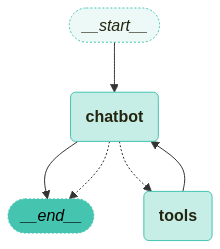

In [19]:
from share.langgraph.graphs import visualize_graph
visualize_graph(graph)

In [20]:
from langchain_core.messages import HumanMessage

question = "한국에 대해 100글자로 요약해줘"
inputs = {"messages": [("user", question)], }
for chunk_msg, metadata  in graph.stream(inputs, stream_mode="messages"):
    if (
        chunk_msg.content
        and not isinstance(chunk_msg, HumanMessage)
        and metadata["langgraph_node"] == "chatbot"
    ):
        print(chunk_msg.content, end="", flush=True)
    # for value in event.values():
    #     print("Assistant:", value["messages"][-1].content)

한국은 동아시아에 위치한 한반도의 국가로, 서울이 수도이다. 고유의 문화와 전통을 가진 한국은 K-팝, 한식, 한복 등으로 세계적으로 알려져 있다. 경제는 기술과 제조업 중심으로 발전하였으며, 교육 수준이 높다. 자연경관이 아름답고 사계절이 뚜렷하다.